# TASK #1: UNDERSTAND THE PROBLEM STATEMENT AND BUSINESS CASE

In this project, we'll create a deep learning model based on CNN and Residual Blocks to predict facial expressions or emotions

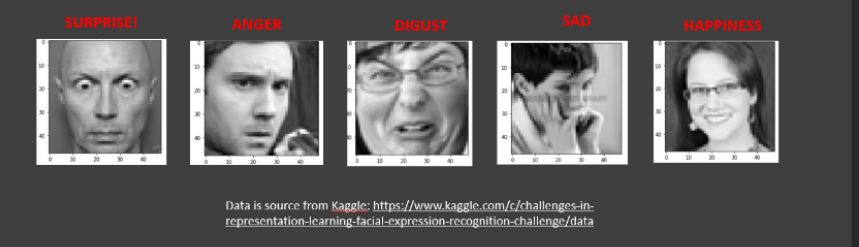


# TASK #2: IMPORT LIBRARIES AND DATASETS

In [ ]:
!pip install tensorflow==2.0

In [ ]:
import tensorflow as tf
tf.version.VERSION

In [ ]:
import cv2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import tensorflow as tf
import pickle
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False) 
# setting the style of the notebook to be monokai theme  
# this line of code is important to ensure that we are able to see the x and y axes clearly
# If you don't run this code line, you will notice that the xlabel and ylabel on any plot is black on black and it will be hard to see them. 


In [ ]:
# read the csv files
emotion_df = pd.read_csv('emotion.csv')

In [ ]:
emotion_df

In [ ]:
emotion_df['emotion'][2]

In [ ]:
emotion_df['pixels'] = emotion_df[' pixels'] # String format

In [ ]:
emotion_df['pixels'][2] # String format

In [ ]:
# function to convert pixel values in string format to array format
def string2array(x):
  return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

In [ ]:
emotion_df['pixels'] = emotion_df['pixels'].apply(lambda x: string2array(x))

In [ ]:
emotion_df['pixels'][2].shape

In [ ]:
emotion_df['pixels'][2]

In [ ]:
# checking for the presence of null values in the data frame
emotion_df.isnull().sum()

In [ ]:
label_to_text = {0:'anger', 1:'disgust', 2:'sad', 3:'happiness', 4: 'surprise'}

In [ ]:
plt.imshow(emotion_df['pixels'][0].squeeze(), cmap = 'gray') 


# TASK #3: PERFORM DATA VISUALIZATION

In [ ]:
emotions = [0,1,2,3,4]

for i in emotions:
  data = emotion_df[emotion_df['emotion'] == i][:1]
  img = data['pixels'].item()
  img = img.reshape(48,48)
  plt.figure()
  plt.title(label_to_text[i])
  plt.imshow(img, cmap= 'gray')

MINI CHALLENGE #2: 
- Plot barplot showing how many samples are present per emotion

In [ ]:
plt.figure(figsize=(10,10))
sns.barplot(x = emotion_df.emotion.value_counts().index, y = emotion_df.emotion.value_counts())
plt.title('Number of images per emotion
          

# TASK #4: PERFORM DATA AUGMENTATION

In [ ]:
emotion_df['pixels'][0]

In [ ]:
emotion_df['emotion'][10]

In [ ]:
X = emotion_df['pixels']
X.shape

In [ ]:
# split the dataframe to features and labels
# from keras.utils import to_categorical

X = emotion_df['pixels']
# y = to_categorical(emotion_df['emotion'])
y = pd.get_dummies(emotion_df['emotion'])

X = np.stack(X, axis = 0)
X = X.reshape(24568, 48, 48, 1)

print(X.shape, y.shape)

In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
X

In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
# spliting the dataframe in to train,test and validation data frames

from sklearn.model_selection import train_test_split

X_train, X_Test, y_train, y_Test = train_test_split(X,y,test_size = 0.1, shuffle = True)
X_val, X_Test, y_val, y_Test = train_test_split(X_Test,y_Test, test_size = 0.5, shuffle = True)


In [ ]:
print(X_val.shape, y_val.shape)

In [ ]:
print(X_Test.shape, y_Test.shape)

In [ ]:
print(X_train.shape, y_train.shape)

In [ ]:
# image pre-processing

X_train = X_train/255
X_val   = X_val /255
X_Test  = X_Test/255

In [ ]:
train_datagen = ImageDataGenerator(
rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode = "nearest"
)


# TASK #5: UNDERSTAND THE INTUITION BEHIND CONVOLUTIONAL NEURAL NETWORKS AND RESNETS

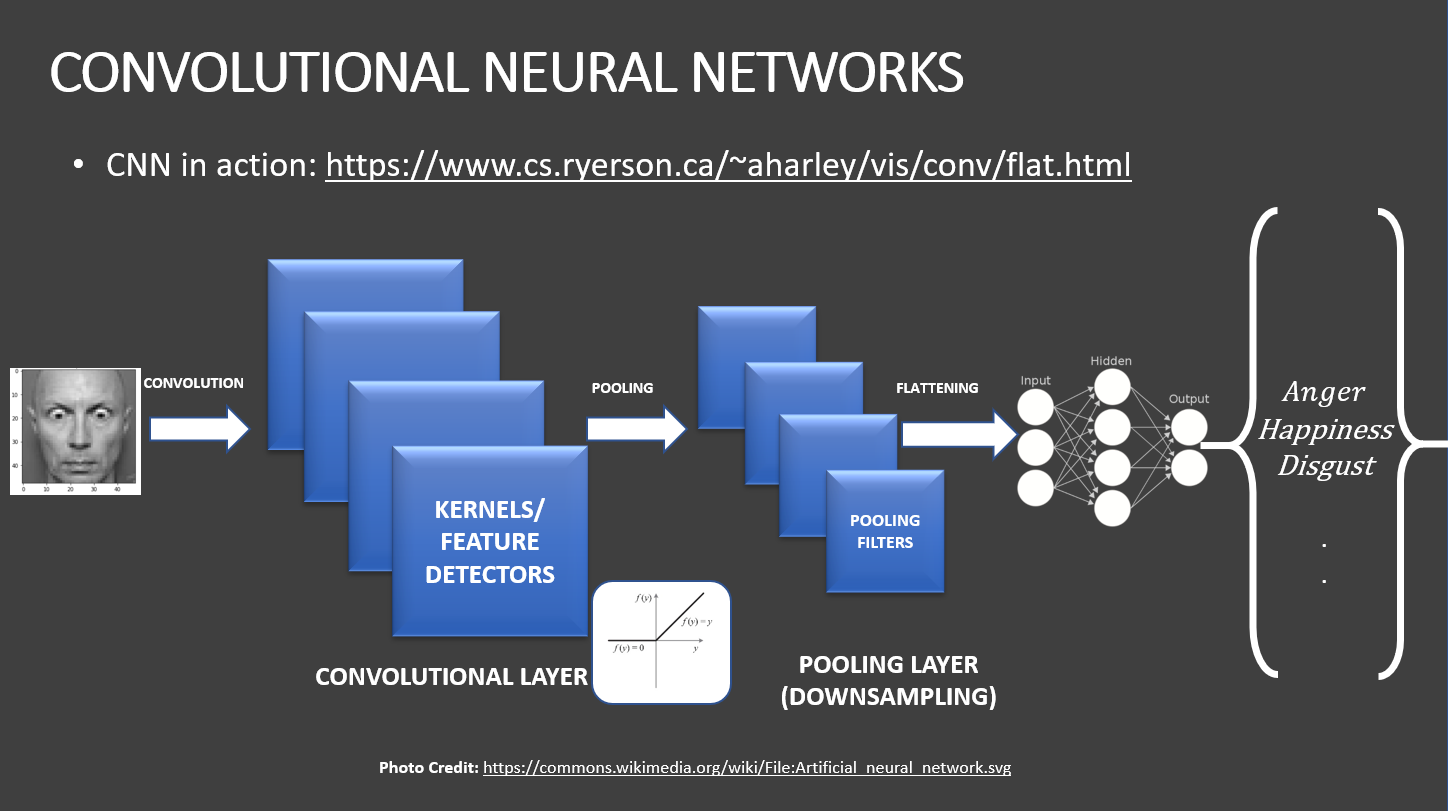

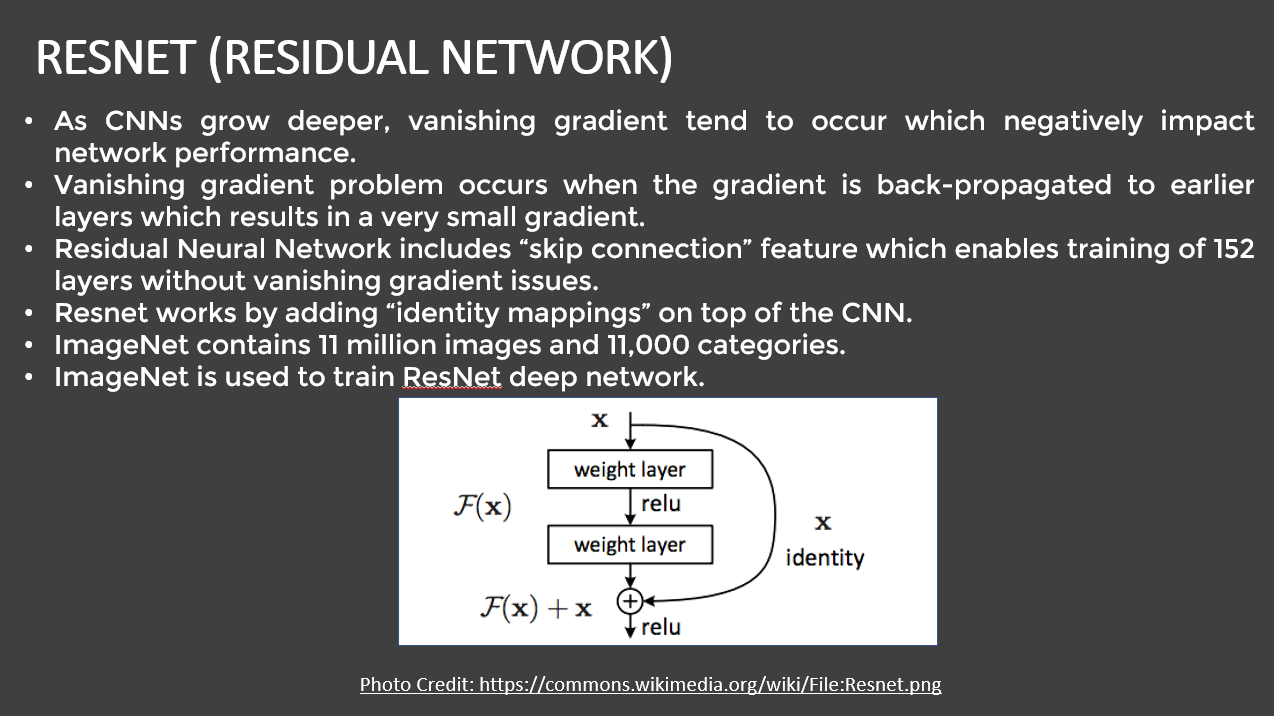

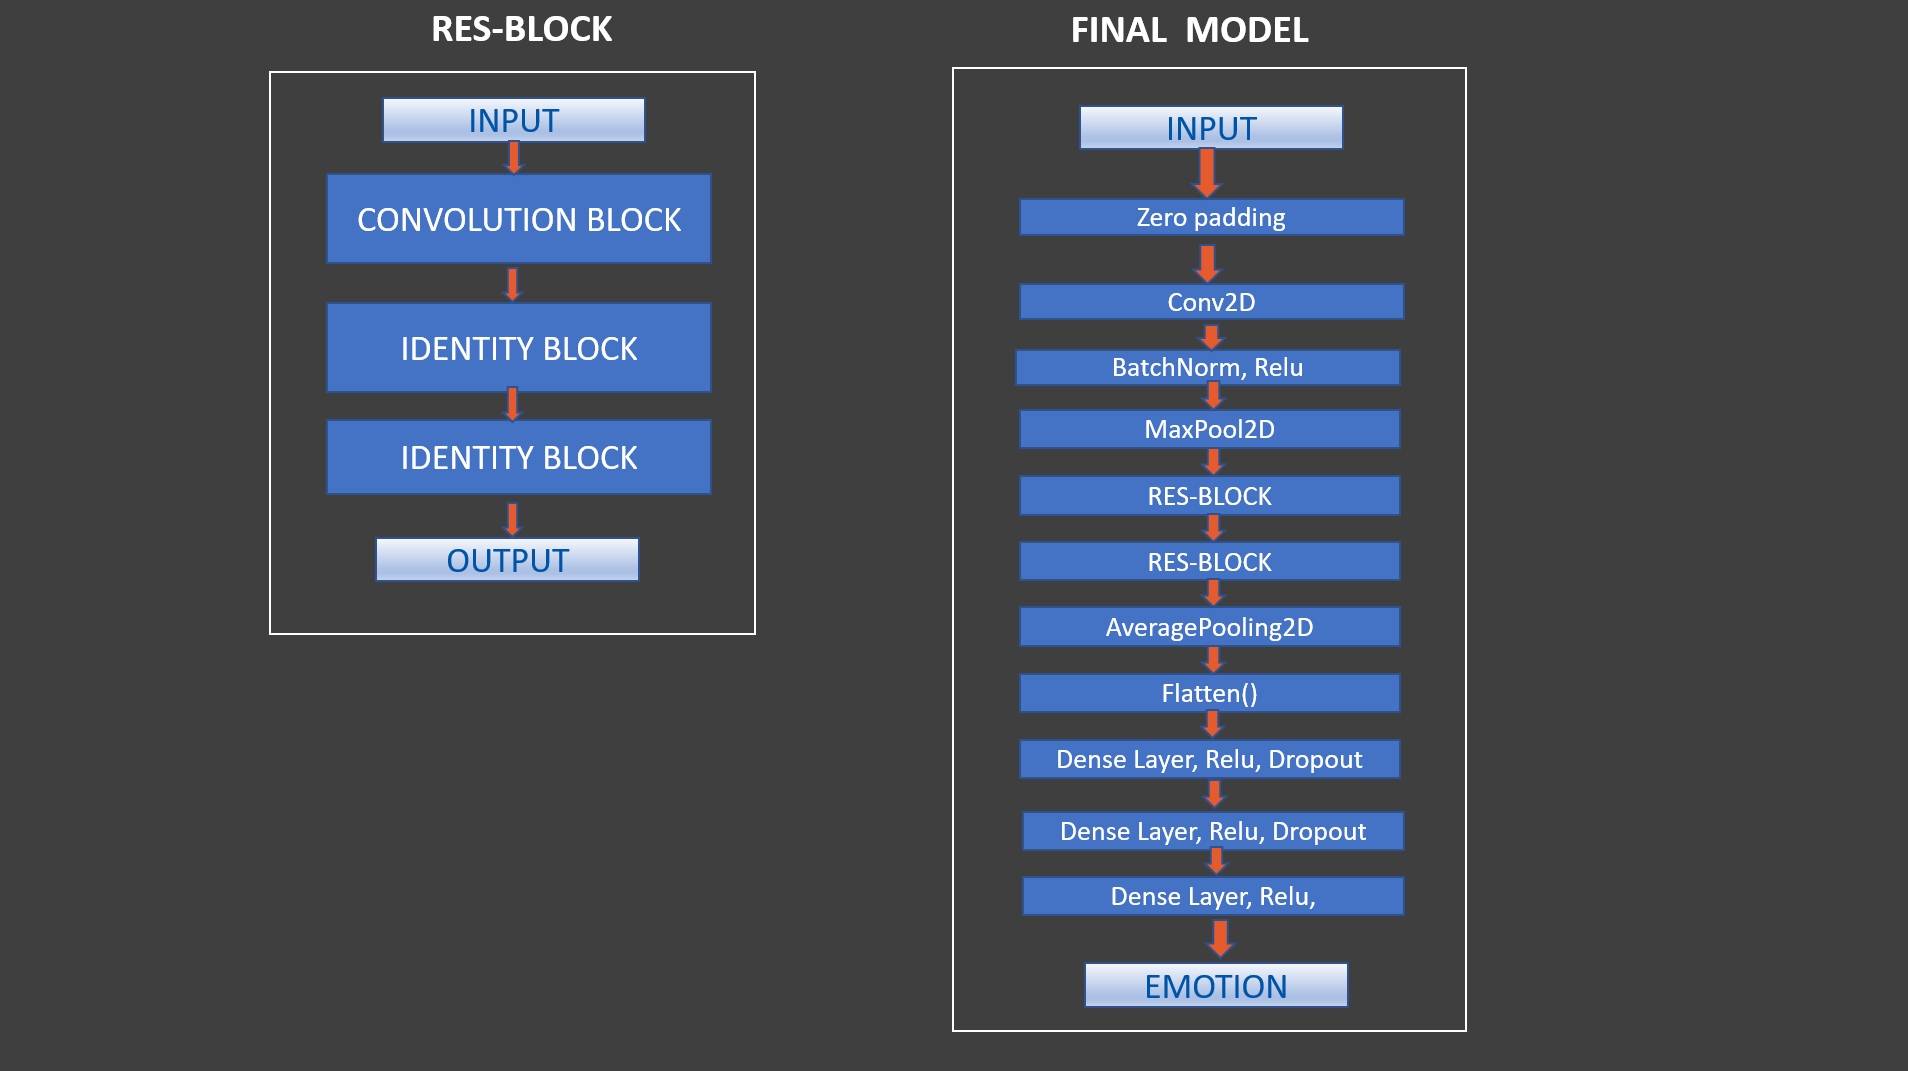

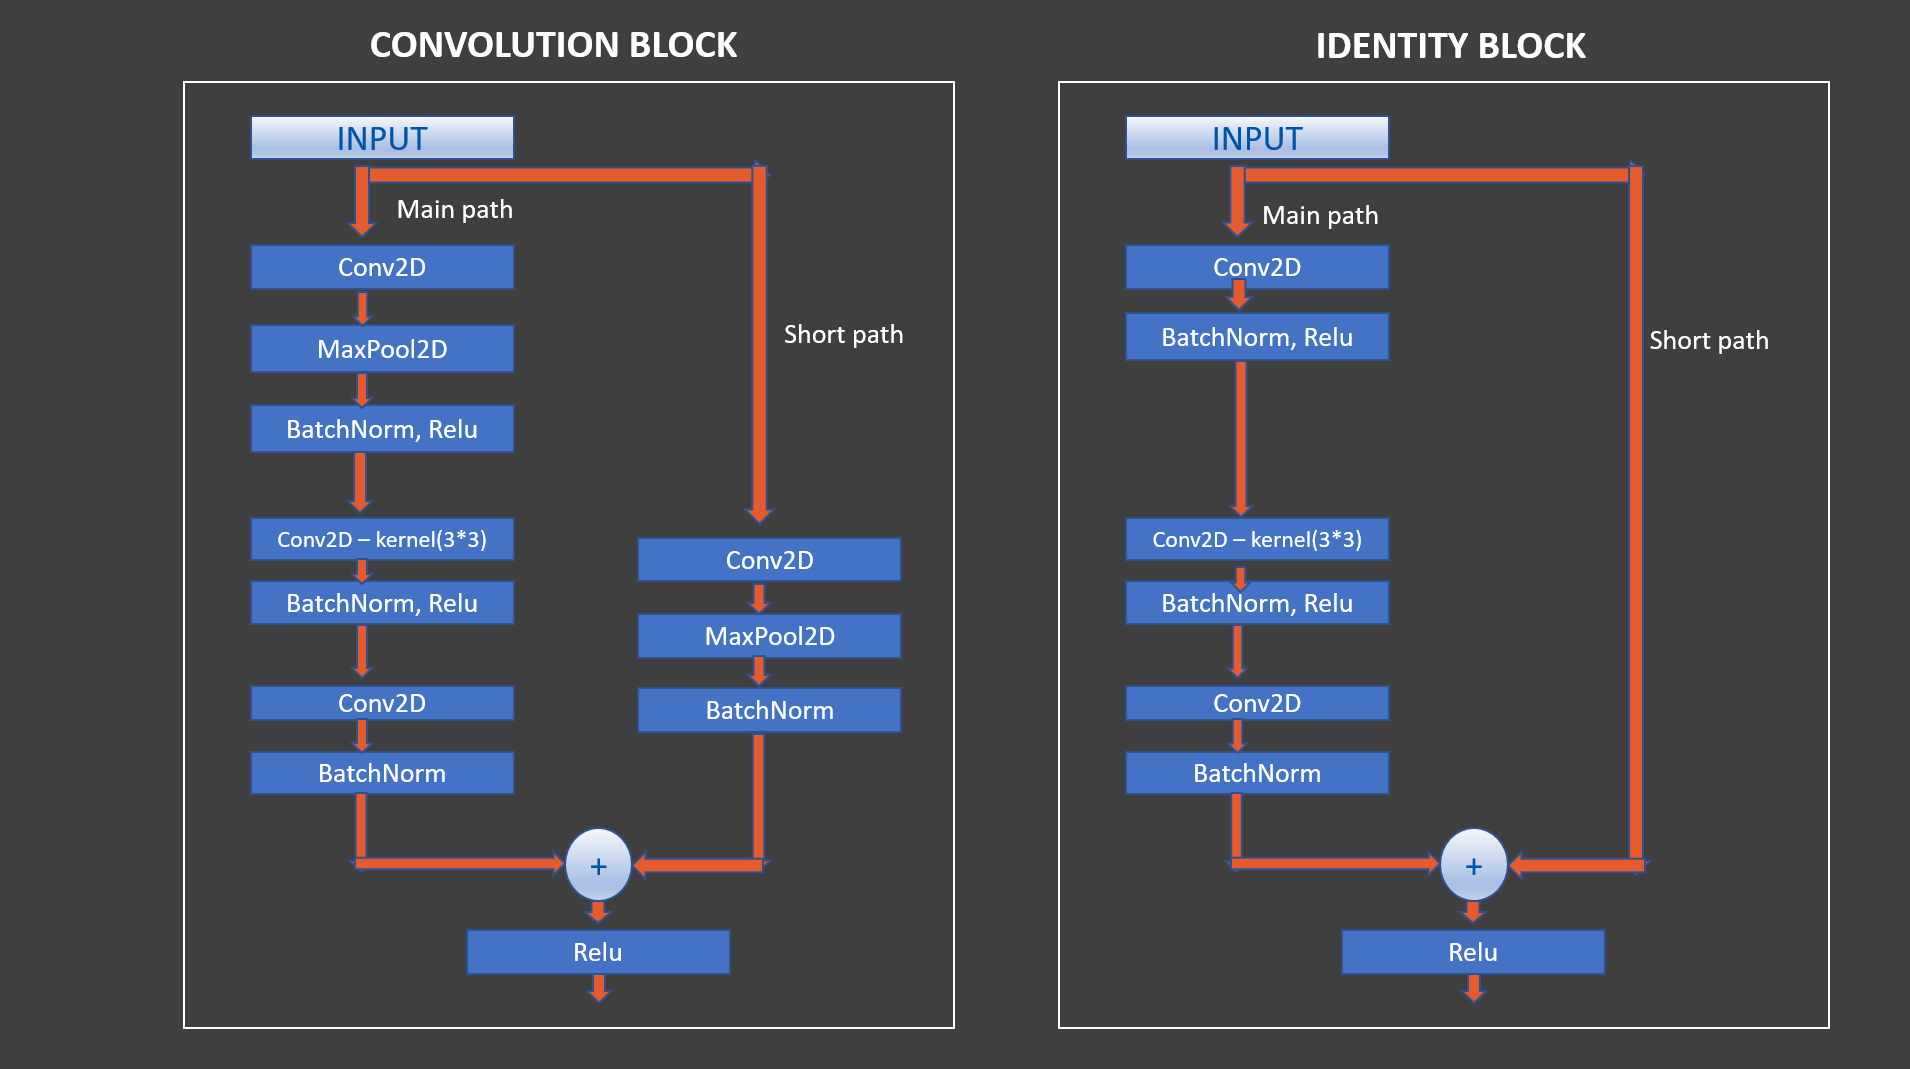

# TASK #6: BUILD AND TRAIN DEEP LEARNING MODEL FOR FACIAL EXPRESSION CLASSIFICATION

In [ ]:
def res_block(X, filter, stage):

  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [ ]:
input_shape = (48, 48, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3, 3))(X_input)

# 1 - stage
X = Conv2D(64, (7, 7), strides= (2, 2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides= (2, 2))(X)

# 2 - stage
X = res_block(X, filter= [64, 64, 256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128, 128, 512], stage= 3)

# 4 - stage
# X = res_block(X, filter= [256, 256, 1024], stage= 4)

# Average Pooling
X = AveragePooling2D((2, 2), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)

model_emotion = Model( inputs= X_input, outputs = X, name = 'Resnet18')

model_emotion.summary()

In [ ]:
# train the network
model_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
# Recall that the first facial key points model was saved as follows: FacialKeyPoints_weights.hdf5 and FacialKeyPoints-model.json

# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = "FacialExpression_weights.hdf5", verbose = 1, save_best_only=True)

In [ ]:
history = model_emotion.fit(train_datagen.flow(X_train, y_train, batch_size=64),
	validation_data=(X_val, y_val), steps_per_epoch=len(X_train) // 64,
	epochs= 20, callbacks=[checkpointer, earlystopping])

In [ ]:
# saving the model architecture to json file for future use

model_json = model_emotion.to_json()
with open("Emotion-model.json","w") as json_file:
  json_file.write(model_json)

# TASK #7: ASSESS THE PERFORMANCE OF TRAINED FACIAL EXPRESSION CLASSIFIER MODEL

In [ ]:
with open('Emotion-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
    
# load the model architecture 
model_emotion = tf.keras.models.model_from_json(json_savedModel)
model_emotion.load_weights('FacialExpression_weights.hdf5')
model_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
score = model_emotion.evaluate(X_Test, y_Test)
print('Test Accuracy: {}'.format(score[1]))

In [ ]:
history.history.keys()

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

In [ ]:
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

In [ ]:
# predicted_classes = model.predict_classes(X_test)
predicted_classes = np.argmax(model_emotion.predict(X_Test), axis=-1)
y_true = np.argmax(y_Test, axis=-1)

In [ ]:
y_true.shape

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, cbar = False)

MINI CHALLENGE #5: 
- Print out a grid of 25 images along with their predicted/true label
- Print out the classification report and analyze precision and recall 

In [ ]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (24, 24))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(X_Test[i].reshape(48,48), cmap = 'gray')
    axes[i].set_title('Prediction = {}\n True = {}'.format(label_to_text[predicted_classes[i]], label_to_text[y_true[i]]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1)   

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, predicted_classes))